In [3]:
! nvidia-smi

Sat Aug  8 06:10:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 2.x

In [4]:
import os
import glob
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set()
import tensorflow as tf
from PIL import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os
import zipfile
local_zip = '/content/drive/My Drive/project datasets/Malaria cell classification.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()
print("Done")

Done


In [5]:
base_dir = os.path.join('/content/Malaria cell classification/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

In [6]:
np.random.seed(42)

df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
r_label={"healthy":0,"malaria":1}

In [8]:
df['m_h']=df['label'].map(lambda rb:r_label[rb])

In [9]:
df.head()

,filename,label,m_h
0,/content/Malaria cell classification/cell_imag...,malaria,1
1,/content/Malaria cell classification/cell_imag...,malaria,1
2,/content/Malaria cell classification/cell_imag...,healthy,0
3,/content/Malaria cell classification/cell_imag...,healthy,0
4,/content/Malaria cell classification/cell_imag...,healthy,0


In [10]:
p=np.random.permutation(len(df))
train_up_to =int(len(df)*0.90)
train_idx=p[:train_up_to]
test_idx=p[train_up_to:]


In [11]:
train_up_to=int(train_up_to *0.9)
train_idx,valid_idx=train_idx[:train_up_to],train_idx[train_up_to:]

In [12]:
from PIL import Image
import albumentations as A
from albumentations import (Compose, OneOf, 
                            CLAHE, Flip, Rotate,GaussNoise,RandomBrightnessContrast,RandomGamma,HorizontalFlip,VerticalFlip)  

In [13]:
def aug(img):
  aug1 = A.Compose(
    [
      A.CLAHE(always_apply=True, p=1.0), 
      A.Rotate(always_apply = True,limit=(-360, 360), border_mode=3, p = 1.0),
      A.VerticalFlip(always_apply=True, p=1.0),
      A.HorizontalFlip(always_apply=True), 
      A.OneOf([
             A.Flip(), 
             A.Rotate()
             ], p=1.0),
      A.OneOf([
            A.GaussNoise(),
          
             ], p=0.9),
          A.OneOf([
            A.RandomBrightnessContrast(),
          
             ], p=0.9),
          A.OneOf([
            A.HorizontalFlip()
          
             ], p=0.9),
          A.OneOf([
            A.RandomGamma(),
          
             ], p=0.9),
    
    ])
  # np.random.seed(42)
  aug_img=aug1(image=img)['image']
  return aug_img
  

In [14]:
def aug1(img):
  aug2 = A.Compose(
    [
      A.CLAHE(always_apply=True, p=1.0)
     
    
    ])
  # np.random.seed(42)
  aug_img=aug2(image=img)['image']
  return aug_img
  

In [15]:
from keras.utils import to_categorical
def get_generator(df,indices,for_training=False,batch_size=16):
  images,mal=[],[]
  while True:
    for i in indices:
      r=df.iloc[i]
      files,l1=r['filename'],r['m_h']
      img=Image.open(files)
      img=img.resize((128,128))
      img=np.array(img)
      img=aug(img)/255.0
      images.append(img)
      mal.append(to_categorical(l1,2))
      if len(images)>=batch_size:
        a=np.array(images)
        b=np.array(mal)
        yield (a,b)
        images,mal=[],[]
    if not for_training:
      break

In [16]:
from keras.utils import to_categorical
def get_generator1(df,indices,for_training=False,batch_size=16):
  images,mal=[],[]
  while True:
    for i in indices:
      r=df.iloc[i]
      files,l1=r['filename'],r['m_h']
      img=Image.open(files)
      img=img.resize((128,128))
      img=np.array(img)
      img=aug1(img)/255.0
      images.append(img)
      mal.append(to_categorical(l1,2))
      if len(images)>=batch_size:
        a=np.array(images)
        b=np.array(mal)
        yield (a,b)
        images,mal=[],[]
    if not for_training:
      break

In [17]:
import keras
from keras.layers import Input,Dense,BatchNormalization,Conv2D,MaxPool2D,GlobalMaxPool2D,Dropout,SeparableConv2D,Dropout,GlobalAvgPool2D
from keras.models import Model

import tensorflow as tf

In [18]:
def conv2d_block(inp,filters=8,bn=True,pool=False,dropout=True):
  _=Conv2D(filters=filters,kernel_size=3,activation='relu',strides=2)(inp)
  if bn:
    _=BatchNormalization()(_)
  if pool:
    _=MaxPool2D()(_)
  if dropout:
    _=Dropout(0.2)(_)
  return _

In [19]:
def sepconv2d_block(inp,filters=8,bn=True,pool=True,dropout=True):
  _=SeparableConv2D(filters=filters,kernel_size=3,activation='relu')(inp)
  if bn:
    _ = BatchNormalization()(_)
  if pool:

    _ = MaxPool2D()(_)
  if dropout:
    _=Dropout(0.2)(_)
  return _

In [20]:
input_layer=Input(shape=(128,128,3))
_=sepconv2d_block(input_layer,filters=32,bn=False)
_=sepconv2d_block(_,filters=32*2)
_=sepconv2d_block(_,filters=32*4)
_=sepconv2d_block(_,filters=32*8)
_=sepconv2d_block(_,filters=32*16)
#_=sepconv2d_block(_,filters=32*32)

bottleneck=GlobalAvgPool2D()(_)
_=Dense(units=512,activation='relu')(bottleneck)
mal_hel=Dense(units=2,activation='sigmoid',name='mal_hel')(_)

model=Model(inputs=input_layer,outputs=mal_hel)
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 126, 126, 32)      155       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 61, 61, 64)        2400      
_________________________________________________________________
batch_normalization (BatchNo (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)       

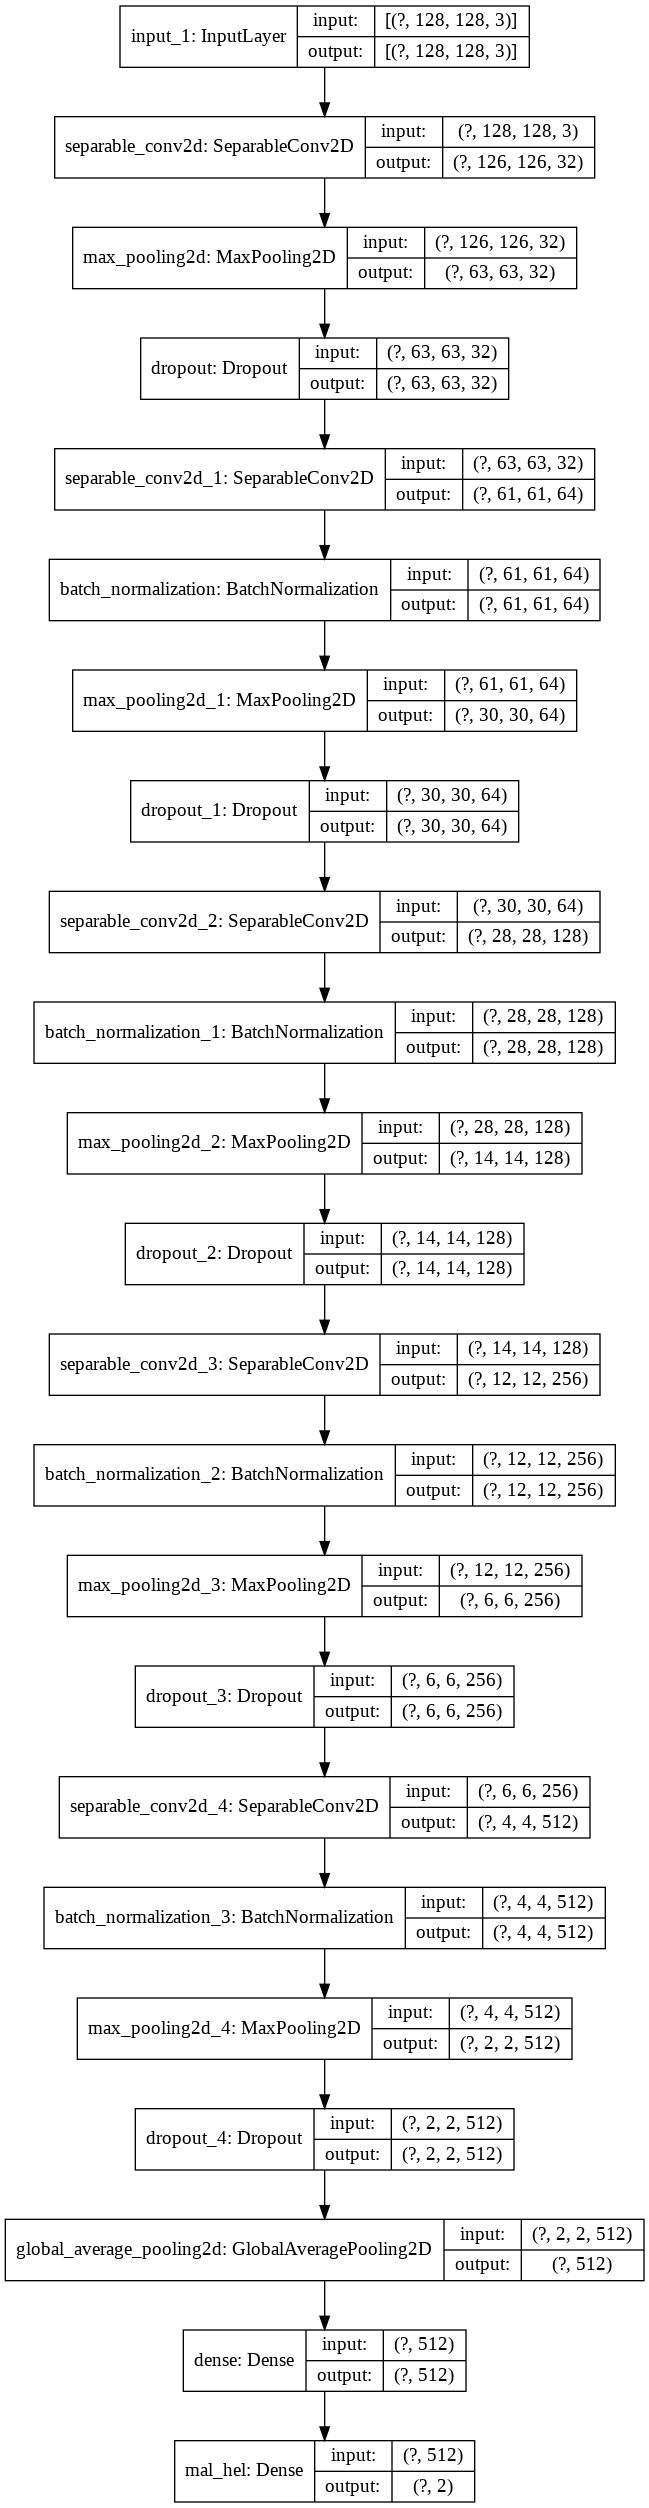

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)

In [22]:
def lr_schedule(epoch):
   
    lr =0.001
    if epoch >15:
        lr *=2**-1
    elif epoch >12:
        lr *=2**(-1)
    elif epoch >8:
        lr *=2**(-1)
    elif epoch >5:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

In [32]:

import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


In [25]:
# optimiser=tf.keras.optimizers.Adam(
#     learning_rate=lr_schedule(0),
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=True,
#     name="Adam"
# )
# bce_fn=tf.keras.losses.BinaryCrossentropy()
# model.compile(optimizer =optimiser , loss =bce_fn , metrics = ['accuracy','AUC'])

In [26]:
opt=tf.keras.optimizers.Nadam(
    learning_rate=lr_schedule(0), beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)
bce_fn=tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=opt,
              loss=bce_fn,
              metrics=["accuracy","AUC"])

Learning rate:  0.001


In [33]:
batch_size=64
valid_batch=64
train_gen=get_generator(df,train_idx,for_training=True,batch_size=batch_size)
valid_gen=get_generator1(df,valid_idx,for_training=True,batch_size=valid_batch)

In [34]:
for i,j in train_gen:
  break
print(i.shape)

(64, 128, 128, 3)


In [35]:
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=15,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//batch_size,callbacks=callbacks)

Learning rate:  0.001
Epoch 1/15
348/348 [==============================] - 191s 550ms/step - loss: 0.4093 - accuracy: 0.7993 - auc: 0.8923 - val_loss: 0.9614 - val_accuracy: 0.5781 - val_auc: 0.7363
Learning rate:  0.001
Epoch 2/15
348/348 [==============================] - 193s 555ms/step - loss: 0.1780 - accuracy: 0.9422 - auc: 0.9781 - val_loss: 0.1716 - val_accuracy: 0.9515 - val_auc: 0.9814
Learning rate:  0.001
Epoch 3/15
348/348 [==============================] - 195s 561ms/step - loss: 0.1590 - accuracy: 0.9484 - auc: 0.9816 - val_loss: 0.1610 - val_accuracy: 0.9535 - val_auc: 0.9836
Learning rate:  0.001
Epoch 4/15
348/348 [==============================] - 197s 566ms/step - loss: 0.1523 - accuracy: 0.9520 - auc: 0.9829 - val_loss: 0.1565 - val_accuracy: 0.9523 - val_auc: 0.9843
Learning rate:  0.001
Epoch 5/15
348/348 [==============================] - 197s 565ms/step - loss: 0.1478 - accuracy: 0.9520 - auc: 0.9842 - val_loss: 0.1612 - val_accuracy: 0.9502 - val_auc: 0.9814


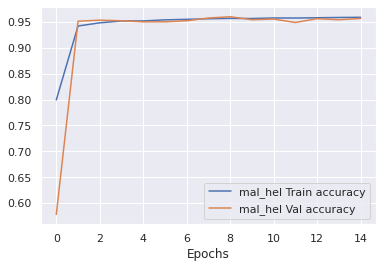

In [36]:
def  plot_train_history(history):
    fig= plt.plot( figsize=(20, 5))
    plt.plot(history.history['accuracy'], label='mal_hel Train accuracy')
    plt.plot(history.history['val_accuracy'], label='mal_hel Val accuracy')
    plt.xlabel('Epochs')
    plt.legend()
plot_train_history(history)

In [37]:
test_gen = get_generator1(df, test_idx, for_training=False, batch_size=32)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//32)))

Instructions for updating:
Please use Model.evaluate, which supports generators.


{'accuracy': 0.9593023061752319,
 'auc': 0.991668164730072,
 'loss': 0.11045069247484207}

In [38]:
for i,j in test_gen:
  break
print(i.shape)
print(j.shape)

(64, 128, 128, 3)
(64, 2)


In [39]:
test_gen = get_generator(df, test_idx, for_training=False, batch_size=32)
x_test, (r_b_true)= next(test_gen)
r_b_pred= model.predict_on_batch(x_test)

In [40]:
r_b_true=r_b_true.argmax(axis=-1)
r_b_pred=r_b_pred.argmax(axis=-1)

In [41]:
from sklearn.metrics import classification_report
print("Classification report for Malaria/Healthy")
print(classification_report(r_b_true,r_b_pred))

Classification report for Malaria/Healthy
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.92      0.96        12

    accuracy                           0.97        32
   macro avg       0.98      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



In [42]:
label={0:'Healthy',1:'Malaria'}

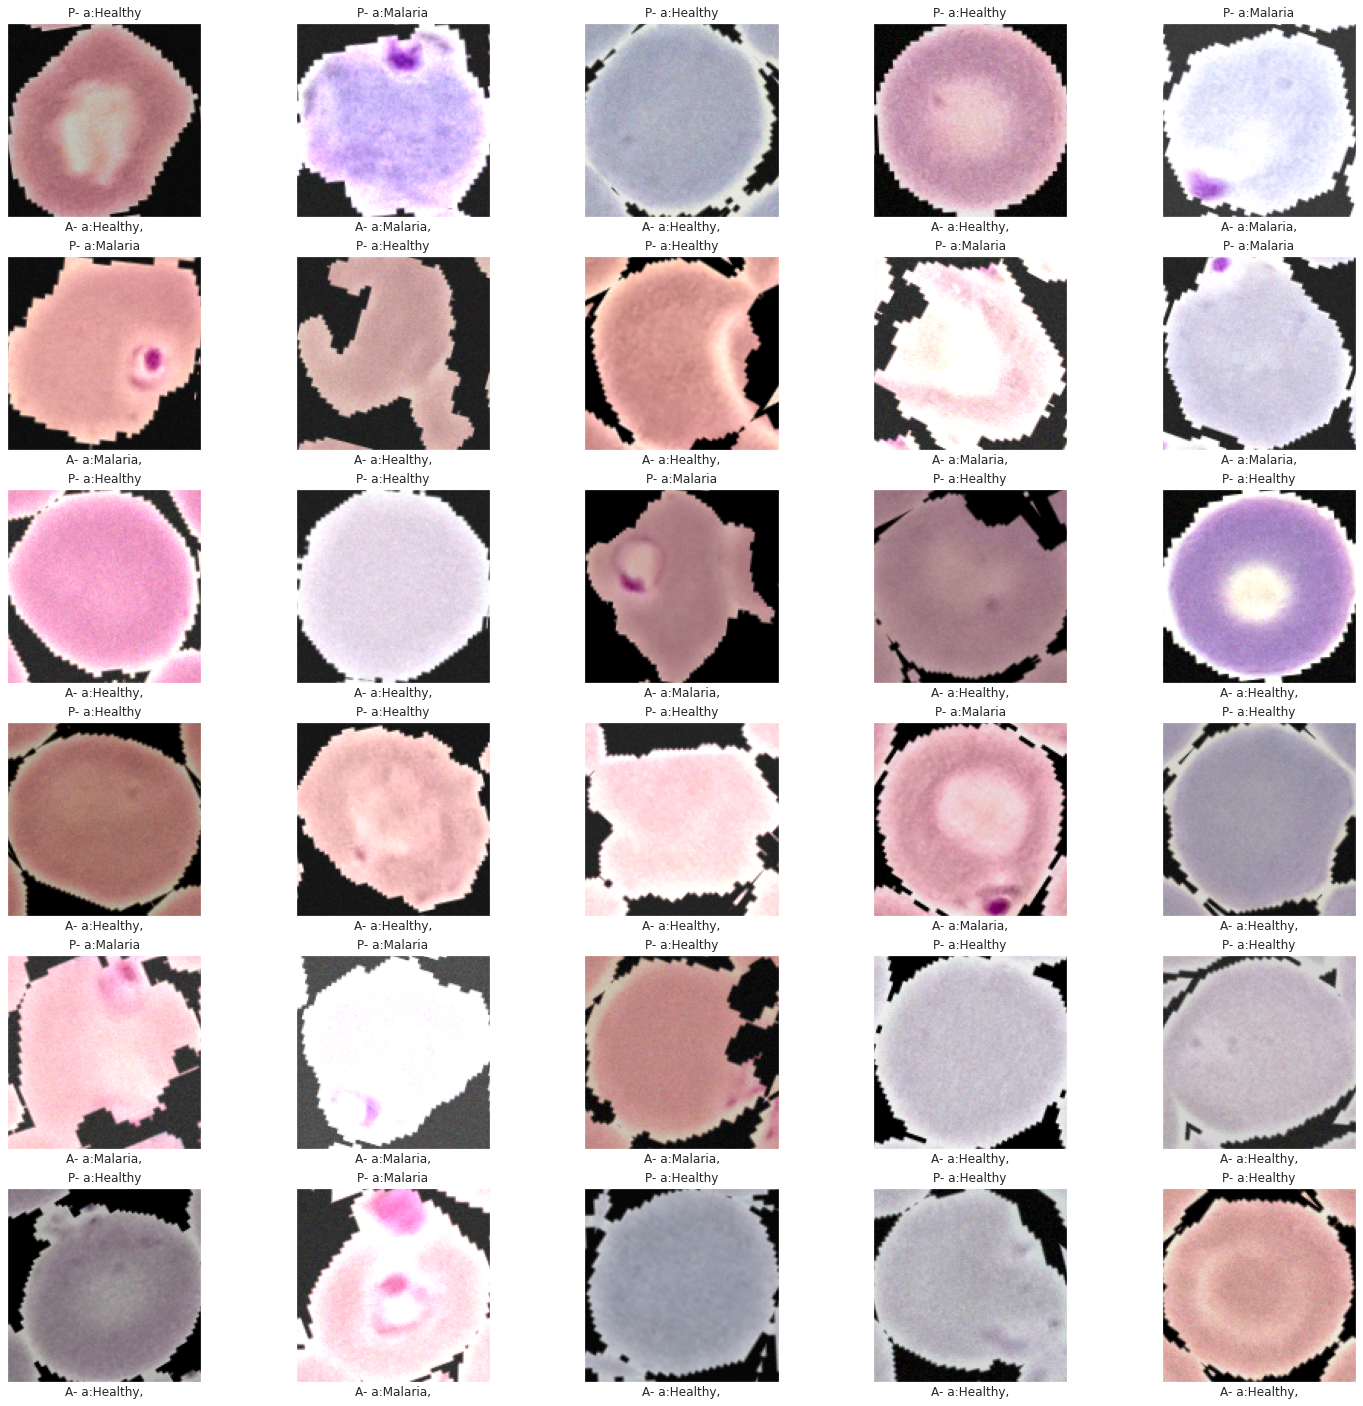

In [43]:
sns.set()
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 25))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('P- a:{}'.format(label[r_b_pred[img_idx]]))
    ax.set_xlabel('A- a:{},'.format(label[r_b_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])


In [ ]:
model.save('/content/drive/My Drive/MOdels/malaria.h5')